In [ ]:
!pip install opencv-python opencv-contrib-python


In [17]:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import HTML
from base64 import b64encode


In [18]:
print("Upload your diamond template image:")
uploaded_template = files.upload()
template_filename = list(uploaded_template.keys())[0]

print("Upload your video file:")
uploaded_video = files.upload()
video_filename = list(uploaded_video.keys())[0]


Upload your diamond template image:


Saving diamonds.png to diamonds.png
Upload your video file:


Saving example1.mp4 to example1.mp4


Diamond Template:


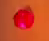

In [19]:
diamond_template = cv2.imread(template_filename)
if diamond_template is None:
    print("Could not read the diamond template image.")
else:
    print("Diamond Template:")
    cv2_imshow(diamond_template)

diamond_template_gray = cv2.cvtColor(diamond_template, cv2.COLOR_BGR2GRAY)
template_h, template_w = diamond_template_gray.shape


In [20]:
cap = cv2.VideoCapture(video_filename)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_filename = 'output_tracking.mp4'
out = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))

# Tracking variables
diamond_detected = False
skull_tracker = None
skull_bbox = None
MATCH_THRESHOLD = 0.8


In [22]:
def detect_skulls(frame):
    """
    Detects potential skulls in the frame based on contours.
    Returns a list of bounding boxes (x, y, w, h).
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    skulls = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if 50 < w < 150 and 50 < h < 150:  # Filter based on size
            skulls.append((x, y, w, h))

    return skulls


In [23]:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert current frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Step 1: Detect the Diamond
    result = cv2.matchTemplate(gray, diamond_template_gray, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    if max_val >= MATCH_THRESHOLD:
        # Draw the diamond box
        top_left = max_loc
        bottom_right = (top_left[0] + template_w, top_left[1] + template_h)
        cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
        cv2.putText(frame, "Diamond", (top_left[0], top_left[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        diamond_detected = True
        diamond_position = top_left

    # Step 2: Identify Skull Covering the Diamond
    if diamond_detected and skull_tracker is None:
        skulls = detect_skulls(frame)

        for skull in skulls:
            sx, sy, sw, sh = skull
            if sx < diamond_position[0] < sx + sw and sy < diamond_position[1] < sy + sh:
                skull_bbox = (sx, sy, sw, sh)
                skull_tracker = cv2.TrackerCSRT_create()
                skull_tracker.init(frame, skull_bbox)
                break  # Stop once we find the first skull covering the diamond

    # Step 3: Track the Skull
    if skull_tracker is not None:
        success, skull_bbox = skull_tracker.update(frame)
        if success:
            x, y, w, h = [int(v) for v in skull_bbox]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(frame, "Skull", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        else:
            cv2.putText(frame, "Lost Skull!", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    # Write frame to output video
    out.write(frame)

# Release resources
cap.release()
out.release()
print("Processing complete. Output saved as", output_filename)


Processing complete. Output saved as output_tracking.mp4


In [24]:
display_video(output_filename, width=500)
files.download(output_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>